The following code goes through the analysis which led to three bullet points available in the README.md file in this repo. 

**Step 1:** Importing the requirements (utilities.py can be found in this repo):

In [24]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import sqlite3
import numpy as np
import seaborn as sns; sns.set(style="white", color_codes=True)
import utilities as u
import warnings 
%matplotlib inline
warnings.filterwarnings("ignore")

**Step 2:** Loading the .csv files with information about customers and transactions.

In [2]:
customers = pd.read_csv('customers.csv', parse_dates=['signup_date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])

In [3]:
customers.head()

,id,signup_date,loyalty,location,gender,age,favorite_movie_line,number_of_purchases,value_of_purchases,total_standard_points,total_points_redeemed
0,1,2012-01-01,enrolled,LA,NaN,oldish,NaN,NaN,NaN,NaN,NaN
1,2,2012-01-01,enrolled,NaN,NaN,youthful,NaN,NaN,NaN,NaN,NaN
2,3,2012-01-01,control,NaN,NaN,wise,"Say ""hello"" to my little friend!",NaN,NaN,NaN,NaN
3,4,2012-01-01,enrolled,NaN,C,young,NaN,NaN,NaN,NaN,NaN
4,5,2012-01-01,enrolled,LA,A,youthful,"Hello, gorgeous.",NaN,NaN,NaN,NaN


**Step 3:** ETL using pandas. In __[Step 4](#step-4)__ I am doing the same process using SQLite. A big chunk of this process is done by funtion `fill_missing_data` which can be found in `utilities.py`.

In [4]:
aggregated_transactions = u.fill_missing_data(transactions)

The `fill_missing_data` function aggregates individual transactions for each customer and fills in missing values in the columns 'number_of_purchases', 'value_of_purchase', 'total_standard_points' and 'total_points_redeemed':

In [5]:
aggregated_transactions.head()

,user_id,number_of_purchases,value_of_purchases,total_points_redeemed,total_standard_points
0,1,3,12934,0.0,1280.0
1,2,4,10041,0.0,990.0
2,3,5,4052,0.0,380.0
3,4,9,20979,0.0,2060.0
4,5,45,107964,10000.0,10600.0


Now I merge two `DataFrames`: `customers` which contains columns with missing data and newly created `aggregated_transactions`: <a class="anchor" id="pandasETL"></a>

In [6]:
customers.rename(columns={'id': 'user_id'}, inplace=True)
customers.drop(['value_of_purchases','total_points_redeemed',
                'total_standard_points','number_of_purchases'],axis=1, inplace=True)
customers_missing_data_filled = pd.merge(customers, aggregated_transactions, on='user_id')
customers_missing_data_filled.head()

,user_id,signup_date,loyalty,location,gender,age,favorite_movie_line,number_of_purchases,value_of_purchases,total_points_redeemed,total_standard_points
0,1,2012-01-01,enrolled,LA,NaN,oldish,NaN,3,12934,0.0,1280.0
1,2,2012-01-01,enrolled,NaN,NaN,youthful,NaN,4,10041,0.0,990.0
2,3,2012-01-01,control,NaN,NaN,wise,"Say ""hello"" to my little friend!",5,4052,0.0,380.0
3,4,2012-01-01,enrolled,NaN,C,young,NaN,9,20979,0.0,2060.0
4,5,2012-01-01,enrolled,LA,A,youthful,"Hello, gorgeous.",45,107964,10000.0,10600.0


The dataset is ready to start exploring & doing some basic stats. In the next step, I will repeat the same process using SQLite, which should run much faster (and writing the query is much less complicated). If you want to skip to the analysis part, click [here](#step-5).

**Step 4:** ETL with SQLite <a class="anchor" id="step-4"></a>

First I verify if the database `customers_transactions.db` exists in the directory and only if it doesn't open the connection and perform the aggregation.

In [25]:
try:
    # Open the connection
    conn = sqlite3.connect('customers_transactions.db')
    # Write the customers and transactions data frames to a local database
    transactions.to_sql("Transactions", conn, flavor='sqlite',index=False)
    customers.to_sql("Customers", conn, flavor='sqlite',index=False)
    # Close the connection
    conn.close()
except ValueError:
    print 'Database already in the current directory, move on.'

Database already in the current directory, move on.


In [8]:
# Open the connection
conn = sqlite3.connect('customers_transactions.db')
a = conn.cursor()

# Write the SQLite query executed in the next step
sql_query = "SELECT user_id, loyalty, signup_date, location,\
            gender, age, favorite_movie_line,\
            count(user_id) as number_of_purchases,\
            sum(value) as value_of_purchases,\
            CASE loyalty\
                WHEN 'control' THEN\
                    0\
                ELSE\
                    sum(round((value/100)*100)/10)\
                END total_standard_points,\
            CASE loyalty\
                WHEN 'control' THEN\
                    0\
                ELSE\
                    sum(round((round((Transactions.value/100)*100)/10 - \
            Transactions.point_differential)/1000)*1000)\
                END total_points_redeemed\
            FROM Transactions JOIN Customers on user_id = id\
            GROUP BY user_id ORDER BY user_id"

df = pd.read_sql_query(sql_query, conn)

# Save (commit) the changes
conn.commit()

# Close the connection
conn.close()

You can compare if the result looks similar to what we got by doing ETL with the result from [Pandas](#pandasETL).

In [9]:
df.head()

,user_id,loyalty,signup_date,location,gender,age,favorite_movie_line,number_of_purchases,value_of_purchases,total_standard_points,total_points_redeemed
0,1,enrolled,2012-01-01 00:00:00,LA,None,oldish,None,3,12934,1280.0,0.0
1,2,enrolled,2012-01-01 00:00:00,None,None,youthful,None,4,10041,990.0,0.0
2,3,control,2012-01-01 00:00:00,None,None,wise,"Say ""hello"" to my little friend!",5,4052,0.0,0.0
3,4,enrolled,2012-01-01 00:00:00,None,C,young,None,9,20979,2060.0,0.0
4,5,enrolled,2012-01-01 00:00:00,LA,A,youthful,"Hello, gorgeous.",45,107964,10600.0,10000.0


**Step 5: Analytics**  <a class="anchor" id="step-5"></a>

First, I will plot the **average purchase value** and **number of purchases** with standard errors of the mean (SEM) and run Welche's t-test to see if there are differences between customers enrolled in the loyalty program and those who are not enrolled.

In [10]:
no_purchases_enrolled = df[df['loyalty']=='enrolled']['number_of_purchases'].tolist()
no_purchases_control = df[df['loyalty']=='control']['number_of_purchases'].tolist()
no_purchases_everybody = df['number_of_purchases'].tolist()

In [11]:
mean_purchase_value_enrolled = (df[df['loyalty']=='enrolled']['value_of_purchases']/
            df[df['loyalty']=='enrolled']['number_of_purchases']).tolist()
mean_purchase_value_control = (df[df['loyalty']=='control']['value_of_purchases']/
           df[df['loyalty']=='control']['number_of_purchases']).tolist()
mean_purchase_value_everybody = (df['value_of_purchases']/df['number_of_purchases']).tolist()

In [12]:
number_of_purchases_means, number_of_purchases_errors = u.get_mean_error(no_purchases_everybody,
                                             no_purchases_enrolled,no_purchases_control)
mean_purchase_value_means, mean_purchase_value_errors = u.get_mean_error(mean_purchase_value_everybody,
                                     mean_purchase_value_enrolled,mean_purchase_value_control)

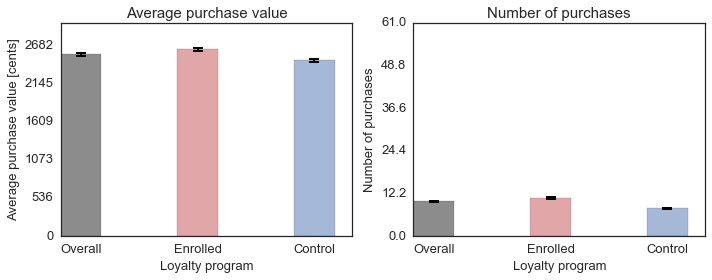

In [32]:
plt.figure(figsize = [10,4])

ax = plt.subplot(121)
title = 'Average purchase value'
ylabel = 'Average purchase value [cents]'
u.bars(mean_purchase_value_means, mean_purchase_value_errors, title, ylabel, ax)

ax = plt.subplot(122)
title2 = 'Number of purchases'
ylabel2 = 'Number of purchases'
u.bars(number_of_purchases_means, number_of_purchases_errors, title2, ylabel2, ax)

plt.tight_layout()
plt.show()

In [14]:
stats.ttest_ind(mean_purchase_value_enrolled,mean_purchase_value_control, equal_var=False)

(4.8538098163165619, 1.2230604134163197e-06)

**Insights**: Looks like we have a significant effect of signing up for the loyalty program. Customers who are enrolled spend on average more money for every purchase (*t* = 4.85, *p* < 0.001) and they also shop more often. However, the loyalty program also costs money - with every applied discount the company spends 500 cents. It seems reasonable to take that into account and adjust the calculations.

What is the revenue from the loyalty program when we take into account the cost of giving customers a discount?

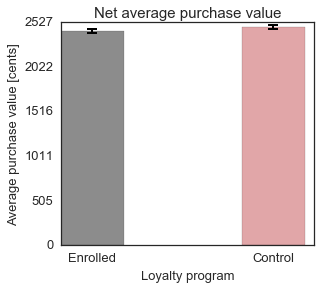

In [15]:
redeemed = df[df['loyalty']=='enrolled']['total_points_redeemed']
av_redeemed = (sum(redeemed)/len(redeemed))/10 # divided by 10 because you can redeem 5000 for 500 cents
err_redeemed = stats.sem(redeemed)

mean_purchase_value_enrolled_ = \
                                [x - av_redeemed for x in mean_purchase_value_enrolled]
                                #shifting the distribution of purchase value of 
                                #customers enrolled in the loyalty program by 
                                #the difference between enrolled and control

aPVMeans_, aPVErrors_ = u.get_mean_error(mean_purchase_value_everybody,
                                         mean_purchase_value_enrolled_,
                                         mean_purchase_value_control)

fig = plt.figure(figsize = [10,4])

ax = fig.add_subplot(121)
title = 'Net average purchase value'
ylabel = 'Average purchase value [cents]'
u.bars(aPVMeans_[1:], aPVErrors_[1:], title, ylabel,ax)

In [16]:
stats.ttest_ind(mean_purchase_value_enrolled_,mean_purchase_value_control, equal_var=False)

(-1.6796866890477078, 0.093038695724951451)

**Insights:** Looks like after adjusting for the cost of the discounts redeemed by the customers the difference in the average purchase value is no longer significant, *t* = -1.67, *p* > 0.05. If I had more time, I would look at the number of purchases - it is possible that since enrolled customers on average shop more often the total net revenue might still be higher. 

Next, I will take a closer look at the time variable. After signing up for the loyalty program customers sometimes don't purchase anything for quite a while. At the extreme, there is one customer who signed up in January, 2012, and hasn't purchased anything until December, 2013.

In [17]:
#at first I wanted to take a look at the times between first and last purchases

first_action = transactions.sort_index().groupby(['user_id'], sort=True, as_index=False).nth(0)
last_action = transactions.sort_index().groupby(['user_id'], sort=True, as_index=False).nth(-1)
session_start_end =\
                pd.merge(first_action, last_action, on = 
                         ['user_id','value', 'point_differential'], 
                         suffixes=('_first_action','_last_action'))
session_start_end['session_length'] =\
                session_start_end['date_last_action'] - session_start_end['date_first_action']
session_start_end = session_start_end.drop(['value','point_differential'], axis=1)
customers_ = pd.merge(session_start_end, df, on = 'user_id')


In [18]:
#Then I decided to turn to time to first purchase 
customers_["signup_date"] = pd.to_datetime(customers_["signup_date"]) #changing the format to datetime
customers_['time_to_first_purchase'] = customers_['date_first_action'] - customers_['signup_date']
customers_['time_to_first_purchase'].describe()
dates_input = customers_["time_to_first_purchase"].values.astype('datetime64[D]')


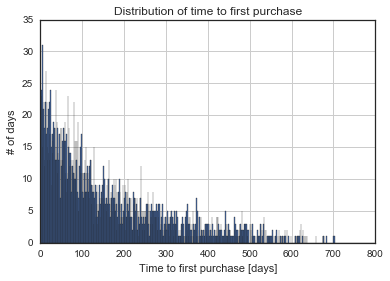

In [19]:
g = (customers_['time_to_first_purchase'] / pd.Timedelta(days=1)).hist(bins=xrange(0, 800, 1))
plt.xlabel('Time to first purchase [days]')
plt.ylabel('# of days');
plt.title('Distribution of time to first purchase')

**Insights:** Looks like most customers make their first purchase shortly after signing up for the loyalty program. 

Is it possible that belonging to the loyalty program makes them spend more money each time they shop?

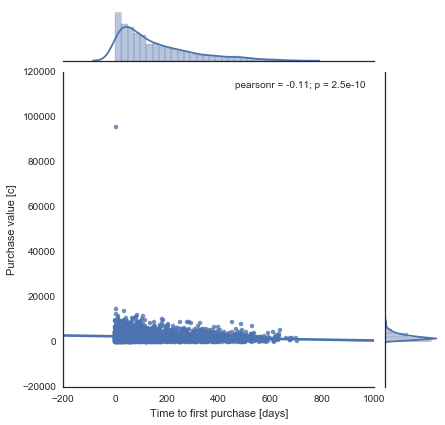

In [26]:
g = (sns.jointplot(x=customers_['time_to_first_purchase'] / pd.Timedelta(days=1),
                   y=customers_['value_of_purchases'],kind='reg')
     .set_axis_labels("Time to first purchase [days]", "Purchase value [c]"));

There seems to be a significant negative correlation between the time to the first purchase and purchase value, which would be clearer if we remove the outlier who spent almost 100 000 cents on a single purchase.

In [21]:
purchases = customers_[customers_['value_of_purchases']<80000]['value_of_purchases']
dates = customers_[customers_['value_of_purchases']<80000]['time_to_first_purchase']

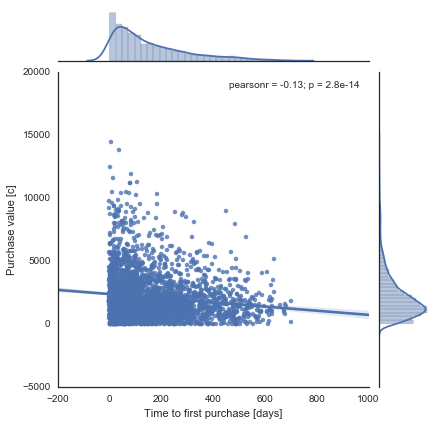

In [22]:
g = (sns.jointplot(x=dates / pd.Timedelta(days=1),y=purchases, kind='reg')
     .set_axis_labels("Time to first purchase [days]", "Purchase value [c]"))

**Insights:** Looks like customers who sign up for the loyalty program tend to spend more money on the purchase soon after becoming members, as indicated by a negative correlation *r* = -0.13, *p* < 0.001. The correlation is weak, but highly significant.

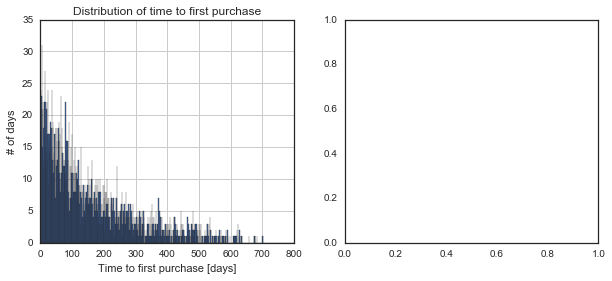

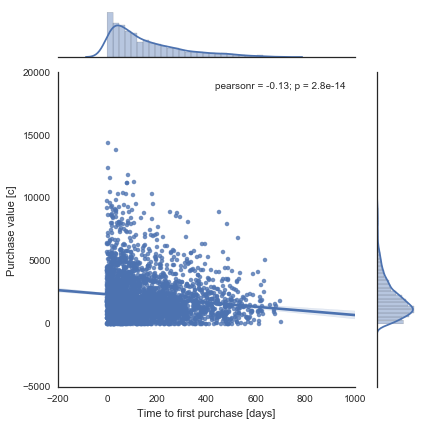

In [33]:
fig = plt.figure(figsize = [10,4])

plt.subplot(121)

(customers_['time_to_first_purchase'] / pd.Timedelta(days=1)).hist(bins=xrange(0, 800, 1))
plt.xlabel('Time to first purchase [days]')
plt.ylabel('# of days');
plt.title('Distribution of time to first purchase')

plt.subplot(122)
(sns.jointplot(x=dates / pd.Timedelta(days=1),y=purchases, kind='reg')
     .set_axis_labels("Time to first purchase [days]", "Purchase value [c]"))

plt.tight_layout()
plt.show()